In [1]:
%cd ..
from src import data_utils, model_utils
from pdpbox import pdp
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
import shap
from codecarbon import EmissionsTracker

/Users/samuelberrebi/Desktop/Projects/DsB/Explainability/Interpretable-jimams


/Users/samuelberrebi/anaconda3/envs/x-hec-solution/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

In [2]:
tracker = EmissionsTracker()

raw_data = pd.read_csv("data/data_clean.csv")
df_one_hot = data_utils.preprocess_data(raw_data)
X, y = df_one_hot.drop('y', axis=1), df_one_hot['y']
X_train, X_test, y_train, y_test = data_utils.split_data(X, y)

[codecarbon INFO @ 15:19:18] [setup] RAM Tracking...
[codecarbon INFO @ 15:19:18] [setup] GPU Tracking...
[codecarbon INFO @ 15:19:18] No GPU found.
[codecarbon INFO @ 15:19:18] [setup] CPU Tracking...
[codecarbon WARNING @ 15:19:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:19:18] We saw that you have a Apple M2 but we don't know it. Please contact us.
[codecarbon INFO @ 15:19:18] CPU Model on constant consumption mode: Apple M2
[codecarbon INFO @ 15:19:18] >>> Tracker's metadata:
[codecarbon INFO @ 15:19:18]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 15:19:18]   Python version: 3.10.10
[codecarbon INFO @ 15:19:18]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 15:19:18]   Available RAM : 16.000 GB
[codecarbon INFO @ 15:19:18]   CPU count: 8
[codecarbon INFO @ 15:19:18]   CPU model: Apple M2
[codecarbon INFO @ 15:19:18]   GPU count: None
[codecarbon INFO @ 15:19:18]   GPU model: None


## Loading the model

In [3]:
# Load the model from the .pkl file
xgb_classifier = pickle.load(open("model/model.pkl", "rb"))


## ICE

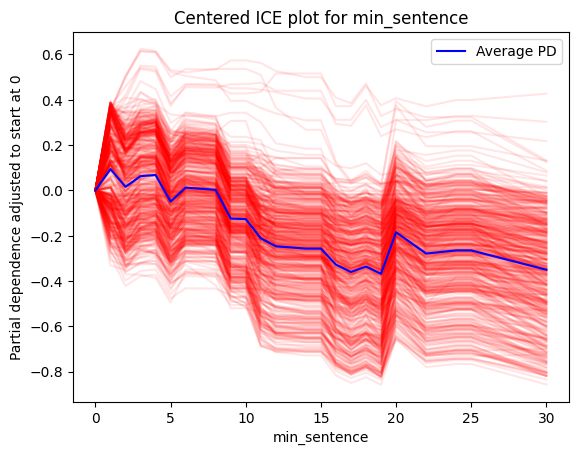

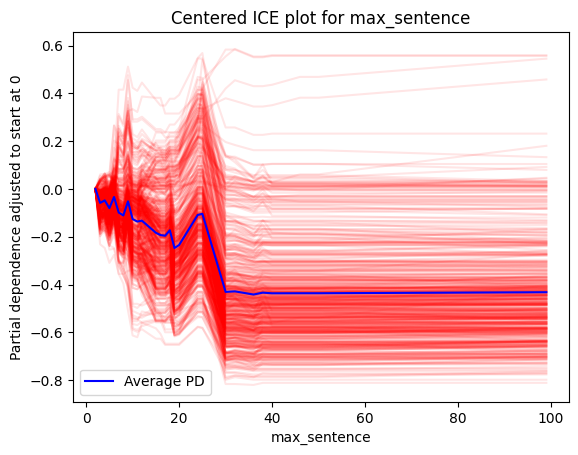

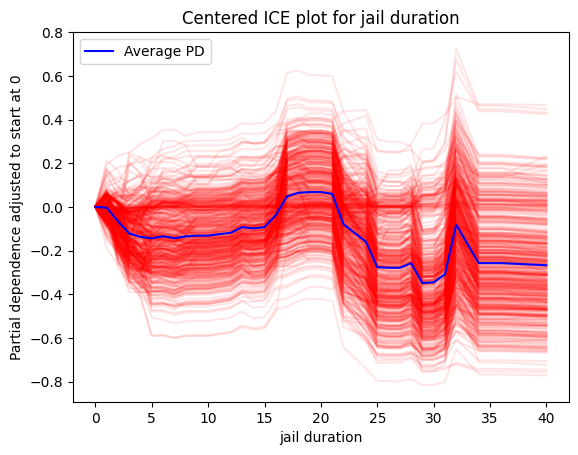

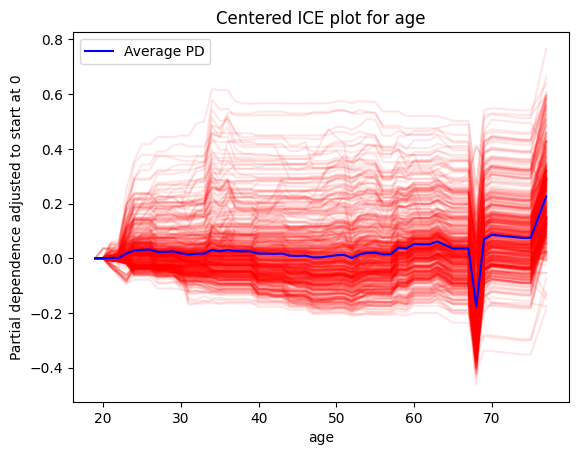

[codecarbon INFO @ 12:38:49] Energy consumed for RAM : 0.000003 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 12:38:49] Energy consumed for all CPUs : 0.000024 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:38:49] 0.000027 kWh of electricity used since the beginning.


1.819306965996491e-06


In [4]:

tracker.start()
# Assuming X_train is your features dataset
features = ['min_sentence', 'max_sentence', 'jail duration', 'age']
feature_names = list(X_train.columns)

# Plot the centered ICE plots
for feature in features:
    # Calculate the partial dependence values
    pdp_result = partial_dependence(xgb_classifier, X_train.sample(n=500,random_state=42), [feature], kind="both")
    
    # Get the individual and average values
    individual_pd = pdp_result.individual[0]
    average_pd = pdp_result.average[0]
    values = pdp_result.grid_values[0]  # Updated from 'values' to 'grid_values'
    
    # Find the index of the minimum feature value to use as a reference
    reference_index = np.argmin(values)
    
    # Centering the ICE data by subtracting the value of each line at the reference index
    individual_centered = individual_pd - individual_pd[:, reference_index, np.newaxis]
    
    plt.figure()
    for ice_line in individual_centered:
        plt.plot(values, ice_line, color='red', alpha=0.1)
    
    # Center the average partial dependence as well
    average_centered = average_pd - average_pd[reference_index]
    
    plt.plot(values, average_centered, color='blue', label='Average PD')
    
    plt.title(f"Centered ICE plot for {feature}")
    plt.xlabel(feature)
    plt.ylabel('Partial dependence adjusted to start at 0')
    plt.legend()
    plt.show()

emissions: float = tracker.stop()
print(emissions)

## SHAP

In [8]:
tracker.start()

# Load JS visualization code to notebook
shap.initjs()
# Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_classifier)
# Calculate SHAP values - this may take some time depending on the size of your dataset and model complexity
X_train_summary = shap.sample(X_train, 100)  # Use a subset of data as a representative for training data
shap_values = explainer.shap_values(X_train_summary)
# Define column grouping for aggregation
columns_to_group = {
    'race / ethnicity': ['race / ethnicity_ASIAN/PACIFIC', 'race / ethnicity_BLACK', 'race / ethnicity_HISPANIC',
                         'race / ethnicity_OTHER', 'race / ethnicity_UNKNOWN', 'race / ethnicity_WHITE'],
    'crime 1 - class': ['crime 1 - class_A', 'crime 1 - class_B', 'crime 1 - class_C', 'crime 1 - class_D', 'crime 1 - class_E'],
    'crime 2 - class': ['crime 2 - class_A', 'crime 2 - class_B', 'crime 2 - class_C', 'crime 2 - class_D', 'crime 2 - class_E'],
    'crime 3 - class': ['crime 3 - class_A', 'crime 3 - class_B', 'crime 3 - class_C', 'crime 3 - class_D', 'crime 3 - class_E'],
    'crime 4 - class': ['crime 4 - class_A', 'crime 4 - class_B', 'crime 4 - class_C', 'crime 4 - class_D', 'crime 4 - class_E'],
    'parole board interview type': ['parole board interview type_INITIAL', 'parole board interview type_MERIT TIME',
                                   'parole board interview type_OTHERS', 'parole board interview type_REAPPEAR']
}
# Aggregate SHAP values for each column group
aggregated_shapley_values = np.zeros((shap_values.shape[0], len(columns_to_group)))
for group_index, (group_name, group_columns) in enumerate(columns_to_group.items()):
    group_indices = [list(X_train_summary).index(column) for column in group_columns]
    group_shapley_values = shap_values[:, group_indices]
    aggregated_shapley_values[:, group_index] = np.sum(group_shapley_values, axis=1)
final_shap_values = np.concatenate([shap_values[:,:8], aggregated_shapley_values, ], axis=1)
concat_X_train_summary = X_train_summary.copy()
#Race
concat_X_train_summary["race"] = X_train_summary[['race / ethnicity_ASIAN/PACIFIC',
       'race / ethnicity_BLACK', 'race / ethnicity_HISPANIC',
       'race / ethnicity_OTHER', 'race / ethnicity_UNKNOWN',
       'race / ethnicity_WHITE']].idxmax(1)
concat_X_train_summary.drop(columns=['race / ethnicity_ASIAN/PACIFIC',
       'race / ethnicity_BLACK', 'race / ethnicity_HISPANIC',
       'race / ethnicity_OTHER', 'race / ethnicity_UNKNOWN',
       'race / ethnicity_WHITE'], inplace=True)
#Crime1
concat_X_train_summary["crime1"] = X_train_summary[['crime 1 - class_A', 'crime 1 - class_B',
       'crime 1 - class_C', 'crime 1 - class_D', 'crime 1 - class_E']].idxmax(1)
concat_X_train_summary.drop(columns=['crime 1 - class_A', 'crime 1 - class_B',
       'crime 1 - class_C', 'crime 1 - class_D', 'crime 1 - class_E'], inplace=True)
#Crime2
concat_X_train_summary["crime2"] = X_train_summary[['crime 2 - class_A', 'crime 2 - class_B', 'crime 2 - class_C',
       'crime 2 - class_D', 'crime 2 - class_E']].idxmax(1)
concat_X_train_summary.drop(columns=['crime 2 - class_A', 'crime 2 - class_B', 'crime 2 - class_C',
       'crime 2 - class_D', 'crime 2 - class_E'], inplace=True)
#Crime1
concat_X_train_summary["crime3"] = X_train_summary[['crime 3 - class_A', 'crime 3 - class_B',
       'crime 3 - class_C', 'crime 3 - class_D', 'crime 3 - class_E']].idxmax(1)
concat_X_train_summary.drop(columns=['crime 3 - class_A', 'crime 3 - class_B',
       'crime 3 - class_C', 'crime 3 - class_D', 'crime 3 - class_E'], inplace=True)
#Crime2
concat_X_train_summary["crime4"] = X_train_summary[['crime 4 - class_A', 'crime 4 - class_B', 'crime 4 - class_C',
       'crime 4 - class_D', 'crime 4 - class_E']].idxmax(1)
concat_X_train_summary.drop(columns=['crime 4 - class_A', 'crime 4 - class_B', 'crime 4 - class_C',
       'crime 4 - class_D', 'crime 4 - class_E'], inplace=True)
#Parole board interview type
concat_X_train_summary["Parole board interview type"] = X_train_summary[['parole board interview type_INITIAL',
       'parole board interview type_MERIT TIME',
       'parole board interview type_OTHERS',
       'parole board interview type_REAPPEAR']].idxmax(1)
concat_X_train_summary.drop(columns=['parole board interview type_INITIAL',
       'parole board interview type_MERIT TIME',
       'parole board interview type_OTHERS',
       'parole board interview type_REAPPEAR'], inplace=True)

emissions: float = tracker.stop()
print(emissions)

[codecarbon INFO @ 15:20:46] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 15:20:46] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:20:46] 0.000001 kWh of electricity used since the beginning.


7.9949598501126e-08


[codecarbon WARNING @ 12:39:04] Already started tracking


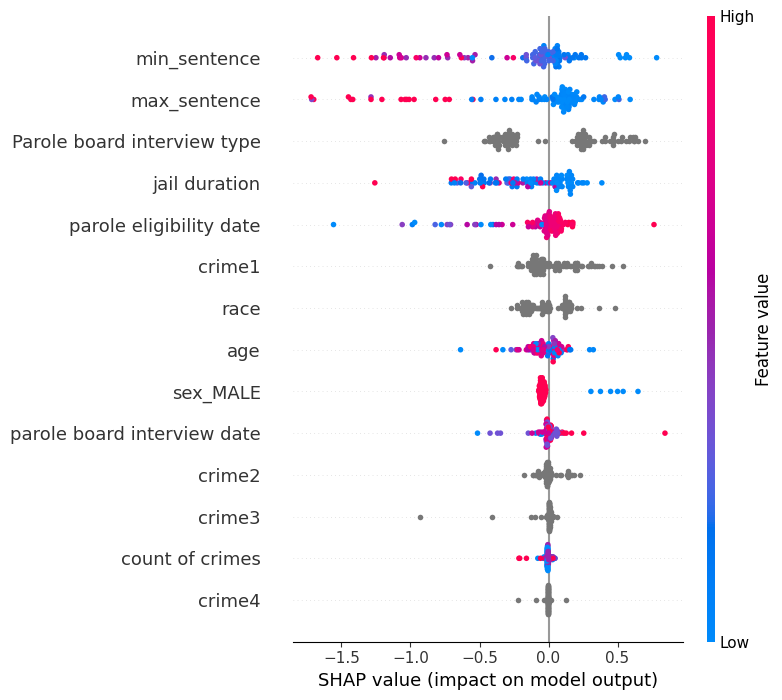

[codecarbon WARNING @ 12:39:04] Tracker already stopped !
[codecarbon INFO @ 12:39:04] Energy consumed for RAM : 0.000029 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 12:39:04] Energy consumed for all CPUs : 0.000205 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:39:04] 0.000234 kWh of electricity used since the beginning.


1.574451959478789e-05


In [6]:
# Summarize the effects of all the features
tracker.start()

shap.summary_plot(final_shap_values, concat_X_train_summary)

emissions: float = tracker.stop()
print(emissions)

In [15]:
# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, final_shap_values[0,:], concat_X_train_summary.iloc[0,:])

In [12]:
# Visualize the second prediction's explanation
shap.force_plot(explainer.expected_value, final_shap_values[1,:], concat_X_train_summary.iloc[1,:])

In [14]:
explainer.